In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt


In [34]:
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

def dlt(originals, correspondence):  ## numpy arrays of the same size
    points_number = np.shape(originals)[0];
    ## o =  orignals
    ## c = correspondence
    o_centroid = np.mean(originals, axis=0)
    c_centroid = np.mean(correspondence, axis=0)
    
    o_centered = originals - np.tile(o_centroid, (points_number,1))
    c_centered = correspondence - np.tile(c_centroid, (points_number,1))
    
    o_norms = np.linalg.norm(o_centered, axis=1)
    c_norms = np.linalg.norm(c_centered, axis=1)                                           
    
    o_distance = np.mean(o_norms)
    c_distance = np.mean(c_norms)
                                          
    o_scale = np.sqrt(2)/o_distance
    c_scale = np.sqrt(2)/c_distance
    
    H_sim_prim = np.array([[c_scale,0      ,-c_centroid[0]*c_scale],
                          [0      ,c_scale,-c_centroid[1]*c_scale],
                          [0      ,0      ,1]])

    
    H_sim = np.array([[o_scale,0      ,-o_centroid[0]*o_scale],
                      [0      ,o_scale,-o_centroid[1]*o_scale],
                      [0      ,0      ,1]])
    
    o_homologous = np.transpose(H_sim @ np.transpose(originals))
    c_homologous = np.transpose(H_sim_prim @ np.transpose(correspondence))

    H_sim_prim = np.linalg.inv(H_sim_prim)
                                             
    A = np.zeros((points_number*2,9))

    zerot = np.array([0,0,0])

    for i in range(0, points_number):
        xt = o_homologous[i, :]
        
        wixt = c_homologous[i,2] * xt
        yixt = c_homologous[i,1] * xt
        xixt = c_homologous[i,0] * xt
        A[2*i,:] = np.concatenate((zerot, -wixt, yixt))
        A[2*i + 1,:] = np.concatenate((wixt, zerot, -xixt))
    (u,d,v) = np.linalg.svd(A)
    
    H = np.reshape(v[-1, :], (3,3))
    H = np.dot(H, H_sim)
    H = np.dot(H_sim_prim, H)
    
    return H

def transf_dlt(H, img):
    img_transf = np.zeros(img.shape)
    img_hist = np.zeros(img.shape)
    vect_ant = np.array([-1,-1,-1])
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            vect = np.array([x,y,1])
            vect = H @ vect
            vect = vect/vect[2]
            #if not(vect[0] == vect_ant[0] and vect[1] == vect_ant[1]):
                #print(vect, x,y)
                #vect_ant = vect
                
            if (int(vect[0])< img.shape[0] and  int(vect[0])>= 0) and (int(vect[1])< img.shape[1] and  int(vect[1])>= 0):
                img_transf[int(vect[0]), int(vect[1]), :] = img[x,y,:].astype(np.uint8)
                img_hist[int(vect[0]), int(vect[1]), 0] += 1
    return (img_transf, img_hist)

(4000, 3000, 3)
87


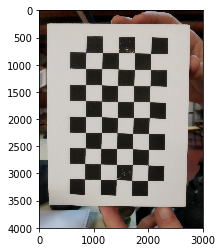

True

In [3]:
damero = cv2.imread('../../dameros/IMG_20181030_174017.jpg')
damero_twist = cv2.imread('../../dameros/IMG_20181030_174022.jpg')
damero_raro = cv2.imread('../../dameros/IMG_20181030_174032.jpg')
gray = cv2.cvtColor(damero,cv2.COLOR_BGR2GRAY)

corners = cv2.goodFeaturesToTrack(gray,100,0.01,10)
corners = np.int0(corners)
print(damero.shape)
cant = 0
for i in corners:
    x,y = i.ravel()
    if(y >= 500 and y <= 3500 and x >= 500 and x <= 2500):
        cv2.circle(damero,(x,y),1,255,-1)
        cant += 1
print(cant)
plt.imshow(damero[:,:,::-1]),plt.show()

cv2.imwrite('damero.png', damero)

100
100


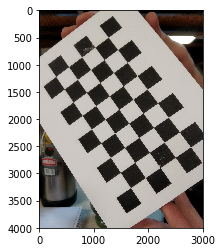

True

In [4]:
gray = cv2.cvtColor(damero_twist,cv2.COLOR_BGR2GRAY)

corners = cv2.goodFeaturesToTrack(gray,100,0.01,10)
corners = np.int0(corners)
print(corners.shape[0])
cant = 0
for i in corners:
    x,y = i.ravel()
    cv2.circle(damero_twist,(x,y),1,255,-1)
    cant += 1
print(cant)
plt.imshow(damero_twist[:,:,::-1]),plt.show()
cv2.imwrite('damero_twist.png', damero_twist)

In [16]:
rect_puntos = np.array([[2358, 510,1],[872, 482,1],[560, 3377,1], [1993, 3137,1]])
gir_puntos = np.array([[1353, 113,1],[169, 1001,1],[1600, 3727,1], [2784, 2521,1]])

H = dlt(gir_puntos, rect_puntos)

In [57]:
aux = np.transpose(H@np.transpose(gir_puntos))
for ar in aux:
    #print(ar/ar[2])
    pass
for elem in gir_puntos:
    sol = H @ elem
    print(sol/sol[2])

[ 2358.000  510.000  1.000]
[ 872.000  482.000  1.000]
[ 560.000  3377.000  1.000]
[ 1993.000  3137.000  1.000]


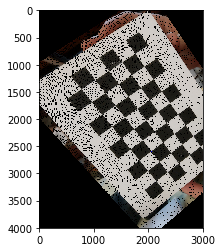

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


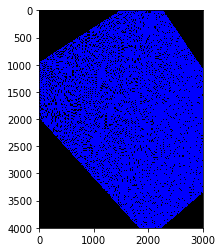

(<matplotlib.image.AxesImage at 0x7fdb3ed878d0>, None)

In [53]:
imagen, hist = transf_dlt(H, damero)
imagen = imagen.astype(np.uint8)
plt.imshow(imagen[:,:,::-1]),plt.show()

plt.imshow(hist[:,:,::-1]),plt.show()

<class 'numpy.float64'> 0.0 <class 'numpy.ndarray'> <class 'numpy.uint8'>


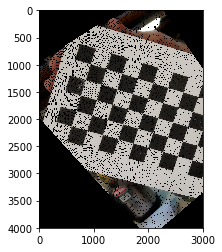

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


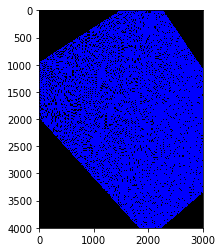

(<matplotlib.image.AxesImage at 0x7fdb3edd9080>, None)

In [52]:
aux = imagen.astype(np.uint8)
histo = hist.astype(np.uint8)
print(type(imagen[1,1,0]),imagen[1,1,0], type(aux), type(aux[1,1,1]))
plt.imshow(aux[:,:,::-1]),plt.show()
plt.imshow(hist[:,:,::-1]),plt.show()

In [ ]:
alphas = {0.9: 4.605, 0.95:5.991, 0.99:9.210}
desvios = [1, 0.5, 1.5]
t_estandar = alphas[0.95]*desvios[1]
sample_size = 2
#points is a np.ndarray

def create_homografic(originals, correspondences):
    ab_ind = np.random.choice(originals.shape[0], size = 2, replace = False) 
    a_ind = ab_ind[0]
    b_ind = ab_ind[1]
    colineal = True
    a = originals[a_ind,:]
    b = originals[b_ind,:]
    ab = np.cross(a,b)
    c = a
    c_ind = a_ind
    while np.cross(ab, c) == 0:
        c_ind = np.random.choice(originals.shape[0])
        c = originals[c_ind, :]
    ac = np.cross(a,c)
    bc = np.cross(b,c)
    d = a
    d_ind = a_ind
    while np.cross(ab, d) == 0 or np.cross(bc, d) == 0 or np.cross(ac, d) == 0:
        d_ind = np.random.choice(originals.shape[0])
        d = originals[d_ind, :]
        
    return dlt(originals[[a_ind, b_ind, c_ind, d_ind]], correspondences[[a_ind, b_ind, c_ind, d_ind]])

    
    
def d_trans(H, original, correspondence):
    inverse = np.linalg.inv(H)
    d = np.linalg.norm(original, inverse @ correspondence)**2
    d += np.linalg.norm(correspondence, H @ original)
    
    return d

def ransac(originals, correspondences):
    t = 5.991 #desvio es 1
    n = 11 #outliers = 40%
    stoping_size = len(point)*0.6
    sample_size = 2
    H = np.array([])
    support = []
    points_idx = list(range(points.shape()[0]))
    
    for i in range(n):
        H_aux = create_homografic(originals, correspondences)
        cant = 0
        suport_aux = []
        for j in range(points.shape()[0]):
            distance = d_trans(H_aux, originals[j,:], correspondencess[j,:])
            if distance <= t:
                support_aux.append(j)
        if len(support) < len(support_aux):
                support = support_aux
                H = H_aux
        if cant >= stoping_size:
            break

    H_big = dlt(originals[support], correspondences[support])
    
    return H_big

In [ ]:
aux[[1,2]]